In [1]:
#### general package ####
import os
import yaml
import pickle
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

#### model package ####
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
with open("../config.yaml", 'r') as f:
    config = yaml.safe_load(f)

data = "CIFAR10"
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(),
                                transforms.Resize((256,256), antialias=True),
                                transforms.Normalize((0), (0.2))])
config['model']["dataset"] = data 

train_dataset = getattr(datasets, data)(root='../data', train=True, download=True, transform= transform)
test_dataset = getattr(datasets, data)(root='../data', train=False, download=True, transform= transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_feat = len(train_dataset[0][0].flatten(0))
batch, _ = next(iter(train_loader))
criterium = nn.L1Loss(reduction = "mean")

Files already downloaded and verified
Files already downloaded and verified


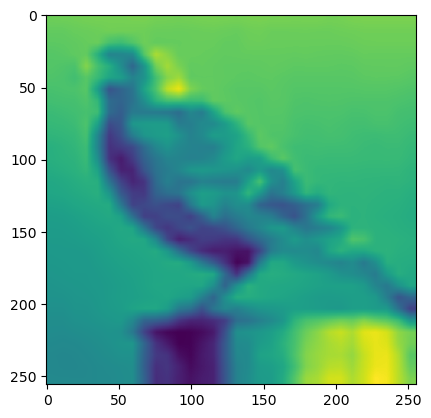

In [3]:
plt.imshow(batch[0,0])

In [4]:
def plot(loss_train: list, 
         loss_val: list, 
         model, 
         ds, 
         config: yaml, 
         transform: None, 
         pieces_of_loss_train:dict = None,
         pieces_of_loss_val:dict = None):
    if type(ds.targets) == list:
        targets = torch.tensor(ds.targets).unique()
    else:
        targets = ds.targets.unique()
    n_images = np.min([config['plot']['n_images'], len(targets)])
    targets = targets[:n_images]
    dataset = config['model']['dataset']             
    show_pieces = config['plot']['show_pieces']
    show_rec = config['plot']['show_rec']
    show_training = config['plot']['show_training']
    model_type = {
        1: "auto",
        2: "vae",
        3: "vae_recurrent"
    }
    model_type = model_type[config['model']['model']]
        
    l = {'epoch' :range(1, len(loss_train)+1),
         'training':loss_train, 
         'validation':loss_val}
    fig = px.line(l, 
                  x ='epoch', 
                  y=['training','validation'],
                  title = "Loss of the training",
                  width = 700, 
                  height = 600)
    if show_training:
        fig.show()
        

    y = list(pieces_of_loss_train.keys())
    y.remove('epoch')
    fig = px.line(pieces_of_loss_train, 
                  x ='epoch', 
                  y= y,
                  title = "pieces of the training loss",
                  width = 800, 
                  height = 700)
    
    fig.write_html(os.path.join(config['paths']['images'],model_type, f'piece_train_{dataset}.html'))
    if show_pieces:
        fig.show()

    fig = px.line(pieces_of_loss_val, 
                  x = 'epoch', 
                  y= y,
                  title = "pieces of the validation loss",
                  width = 800, 
                  height = 700)
    
    fig.write_html(os.path.join(config['paths']['images'],model_type, f'piece_val_{dataset}.html'))
    if show_pieces:
        fig.show()
             
    #reconstruction part

    fig, axes = plt.subplots(nrows = n_images, 
                             ncols = 2, 
                             figsize = (6, n_images*3),
                             constrained_layout=True)
    title = {
        1: "Autoencoder",
        2: "Variational autoencoder",
        3: "Vae Recurrent"
    }
    title = title[config['model']['model']]

    fig.suptitle(f"{title} {model.hidden_dim}D for {dataset}")
    with torch.no_grad():
        for i, target in enumerate(targets):
            if type(ds.targets) == list:
                data = ds.data[[True if x == i else False for x in ds.targets]][0]
            else:
                data = ds.data[ds.targets==target][0].numpy()

            data = transform(data)[0]
            data = data.unsqueeze(0) if len(data.shape) == 2 else data

            if config['model']['model'] in [2,3]: 
                recon, _, _, _,_ = model(data.float().to(model.device))
            else:
                recon = model.cpu()(data.float().flatten(1))
            axes[i,0].imshow(data[0], cmap = 'gray')
            axes[i,1].imshow(recon.detach().cpu().numpy().reshape(data.shape[1:]), cmap = 'gray')
        
            axes[i,0].set_title("real")
            axes[i,1].set_title("reconstructed")
    plt.savefig(os.path.join(config['paths']['images'],model_type, f'rec_{model.hidden_dim}D_{dataset}.png'))    
    if show_rec:
        plt.show()
    else:
        plt.close()


# Model

In [10]:
class dist_fun(nn.Module):
    def __init__(self,
                 inverse: bool, 
                 hidden_dim:int = 64):
        super(dist_fun, self).__init__()
        self.hidden_dim = hidden_dim
        self.inverse = inverse
        # Encoder layers        
        fc1 = [nn.Linear(1, hidden_dim), 
               nn.Sigmoid(), 
               nn.Linear(hidden_dim, 1)]

        self.fc1 = nn.Sequential(*fc1)
    
    def forward(self, x):
        return self.fc1(x)
        
    def derivative(self, y, x):
        derivative = torch.autograd.grad(y, x, 
                                       grad_outputs = torch.ones_like(x),
                                       create_graph = True, 
                                       retain_graph = True)[0]
        return derivative

# Define VAE model
class VAE(nn.Module):
    def __init__(self,
                 input_feat: int,
                 criterium,
                 device, 
                 hidden_dim: int):
        super(VAE, self).__init__()

        # Encoder layers
        self.criterium = criterium
        self.hidden_dim = hidden_dim
        self.device = device
        self.input_feat = input_feat
        self.upper_bound_var = torch.tensor([5.]*hidden_dim, device = device, requires_grad = True).float()
        self.fc1 = nn.Sequential(nn.Flatten(1),
                                 nn.Linear(input_feat, 512),
                                 nn.Tanh(),
                                 nn.Linear(512, 256))
        
        self.fc_mu = nn.Sequential(nn.Linear(256, 128),
                                   nn.Tanh(),
                                   nn.Linear(128, hidden_dim))
        
        self.fc_logvar = nn.Sequential(nn.Linear(256, 128),
                                       nn.Tanh(),
                                       nn.Linear(128, hidden_dim))

        # Decoder layers
        
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, 128),
                                 nn.Tanh(),
                                 nn.Linear(128, 256),
                                 nn.Tanh(),
                                 nn.Linear(256, 512),
                                 nn.Tanh(),
                                 nn.Linear(512, input_feat))

        #### F^{-1}(u) ####
        self.F_inv = dist_fun(inverse = True)

        #### F(F^{-1}(u)) ####
        self.F = dist_fun(inverse = False)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        log_var = torch.max(torch.min(log_var,torch.ones_like(log_var)*4),torch.ones_like(log_var)*(-4)) 
        var = torch.exp(log_var)
        return mu, var#.view(-1,self.hidden_dim, self.hidden_dim)

    def decode(self, z):
        return self.fc2(z)

        
    def reparameterize(self, mu, var):

        #### Generating the random distribution #####
        u = torch.rand_like(mu, requires_grad = True).float().view(-1,1)
        x = self.F_inv(u)
        u_hat = self.F(x)
        
        ### Perturbing the embedding 
        z = mu + var*x.view(-1,self.hidden_dim)#torch.bmm(var,x.view(-1,self.hidden_dim, 1)).view(-1, self.hidden_dim)
        return z, u, u_hat, x
    
    def forward(self, x):
        mu, var = self.encode(x.view(-1, self.input_feat))
        z, u, u_hat, x, = self.reparameterize(mu, var)
        x_reconstructed = self.decode(z)
        
        return x_reconstructed, u, x, u_hat, var
    
    
    def loss_density(self):
        u = torch.rand(500, requires_grad = True).view(-1,1).float().to(self.device)
        X = self.F_inv(u)

        ### Voglio che mu = 0 e std = 1
        mean = torch.abs(torch.mean(X))
        std = torch.mean(X**2)

        #### proprietà densità
        x = torch.tensor([-30.], requires_grad = True).float().to(self.device)
        lower = self.F(x)[0]
        upper = self.F(-x)[0]

        domain = torch.linspace(-20, 20, 
                               steps = 500, 
                               requires_grad = True).view(-1,1).float().to(self.device)     ## positività
        
        y = self.F(domain.requires_grad_())
        
        density = self.F.derivative(y,domain)
        p = torch.sum(density)
        positivity = torch.sum(F.relu(-density))      # f(x)>= 0
        ####### Constraints della distribuzione 
        one = torch.tensor(1.).to(self.device)
        # media 0
        l = mean
        # varianza 1
        std_loss = self.criterium(std, one)
        # upper = 1 ==> F(infty)=1
        upper_loss = self.criterium(upper, one)
        #lower = 0 ==> F(-infty)= 0
        lower_loss = torch.sum(lower)
        # int f(x)dx = 1
        normality = self.criterium(p, one)

        l = mean + std_loss + upper_loss + lower_loss + positivity + normality
        
        return l, (mean.item(), std_loss.item(), upper_loss.item(), lower_loss.item(), positivity.item(), normality.item())

    def loss_functional(self, img, img_rec, u, x, u_hat, var):
        density1 = self.F_inv.derivative(x, u)
        density2 = self.F.derivative(u_hat, x)

        l = 0
    
        #### chain rule
        identity = self.criterium(density1, 1/density2)
        ### reconstruction loss for distribution
        reconstruction1 =  self.criterium(u, u_hat)
        ### reconstruction loss for image
        reconstruction2 = self.criterium(img, img_rec)
        ### Kullenback Leiberg divergence

        l = identity + reconstruction1 + 500*reconstruction2
        
        kl = torch.mean(torch.log(density2[density2>0]))
        #logA = torch.mean(torch.log(torch.linalg.det(var)))
        det_var = torch.prod(var,1)
        if torch.any(det_var<0):
            print("det negativo")
        logA = torch.mean(torch.log(det_var))
        if torch.any(torch.isnan(kl)) or torch.any(torch.isnan(logA)):
            kl = torch.tensor(0, device = self.device).float()
        else:
            kl = logA-kl
        l += kl
        l += 1/torch.mean(det_var)
        return l, (identity.item(), reconstruction1.item(), reconstruction2.item(), kl.item())

In [11]:
def step(model, 
         dataloader,
         optimizer,
         pieces_of_loss: dict, 
         training: bool = False):
    loss_epoch = 0.0
    len_load = len(dataloader)
    if training:
        model.train()
    else:
        model.eval()
    for data, _ in iter(dataloader):
        # blocking the gradient summation 
        optimizer.zero_grad()

        # forward step
        x_reconstructed, u, x, u_hat, var  = model(data.to(model.device).float())
        
        # computing the loss
        l1, dens = model.loss_density()
        l2, func = model.loss_functional(data.to(model.device).flatten(1).float(), x_reconstructed, u, x, u_hat, var)
        loss = l1 + l2 
        
        pieces = dens + func
        if torch.any(torch.isnan(loss)).item():
            print(dens)
            print(func)
        # Backward and optimize
        if training:
            loss.backward()
            optimizer.step()
        
        loss_epoch += loss.item()
        for i, key in enumerate(pieces_of_loss.keys()):
            if 'std_emb' == key:
                pieces_of_loss[key][-1] += torch.mean(torch.prod(var,1)).item()/len_load
            else:
                pieces_of_loss[key][-1] += pieces[i]/len_load
    return loss_epoch/len_load

def training(model, 
             train_loader, 
             val_loader, 
             num_epochs,
             optimizer):
    loss_train = []
    loss_val = []
    be = np.inf
    bm = model
    
    pieces_of_loss_train = {'mean':[], 'std_loss':[], 'upper_loss':[], 'positivity':[], 'normality':[], 'identity':[], 'reconstruction1':[], 'reconstruction2':[], 'kl_loss':[], 'std_emb':[]}    
    pieces_of_loss_val = {'mean':[], 'std_loss':[], 'upper_loss':[], 'positivity':[], 'normality':[], 'identity':[], 'reconstruction1':[], 'reconstruction2':[], 'kl_loss':[], 'std_emb':[]}    
    model.train()

    for epoch in tqdm(range(num_epochs)):    
        for key in pieces_of_loss_train.keys():
            pieces_of_loss_train[key].append(0)
            pieces_of_loss_val[key].append(0)
        l = step(model, train_loader, optimizer, pieces_of_loss_train, True)
        loss_train.append(l)

        l = step(model, val_loader, optimizer,pieces_of_loss_val)
        loss_val.append(l)
        
        if (epoch+1)%5==0:
            print(f"loss training at the {epoch+1}-th = {loss_train[-1]}")
            print(f"loss validation at the {epoch+1}-th = {loss_val[-1]}")
            
        if loss_val[-1]<be:
            be = loss_val[-1]
            bm = model
    pieces_of_loss_train['epoch'] = list(range(1, num_epochs+1))
    pieces_of_loss_val['epoch'] = list(range(1, num_epochs+1))
    return bm, loss_train, loss_val, pieces_of_loss_train, pieces_of_loss_val


In [12]:
model = VAE(input_feat= input_feat, 
            hidden_dim = config['model']['hidden_dimension'], 
            device = device, 
            criterium = criterium).to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3) 



In [13]:
# Training the vae
model, loss_train, loss_val, piece_train, piece_val = training(model = model, 
                                                                train_loader = train_loader, 
                                                                val_loader = test_loader, 
                                                                num_epochs = 2, #config['optimizer']['epochs'], 
                                                                optimizer = optimizer)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

> /tmp/ipykernel_15433/911410771.py(108)loss_density()
    106         import pdb
    107         pdb.set_trace()
--> 108         std = torch.mean(X**2)
    109 
    110         #### proprietà densità



ipdb>  mean


tensor(0.1182, device='cuda:0', grad_fn=<AbsBackward0>)


ipdb>  q


  0%|                                                     | 0/2 [01:08<?, ?it/s]


In [15]:
plot(loss_val, 
            loss_val, 
            model, 
            ds = train_dataset, 
            config=config,
            transform= transform ,
            pieces_of_loss_train = piece_val, 
            pieces_of_loss_val = piece_val)